In [65]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn import tree

In [66]:
# Создаём обучающую выборку
ames_data = pd.read_csv('AmesHousing.csv')
ames_data = ames_data[(ames_data['Lot Frontage'] <=150) & (ames_data['Lot Area'] <=20000)]
X = ames_data[['Lot Frontage', 'Lot Area']]
y = ames_data['SalePrice']

In [67]:
# Инициализируем модель дерева решений с максимальной глубиной 3 и обучаем её
dt_reg = tree.DecisionTreeRegressor(max_depth=3)
dt_reg.fit(X.values, y)

DecisionTreeRegressor(max_depth=3)

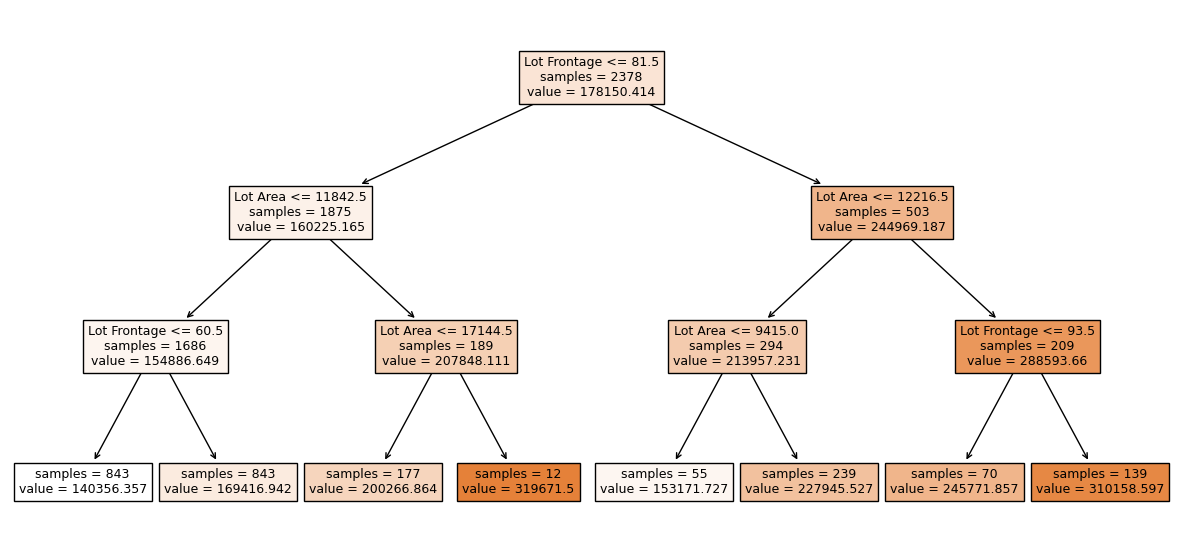

In [68]:
# Визуализируем дерево решений в виде графа
fig = plt.figure(figsize=(15, 7))
tree_graph = tree.plot_tree(
    dt_reg, #дерево решений 
    feature_names=X.columns, #имена факторов
    filled=True, #расцветка
    impurity=False, #отображать ли неоднородность
);

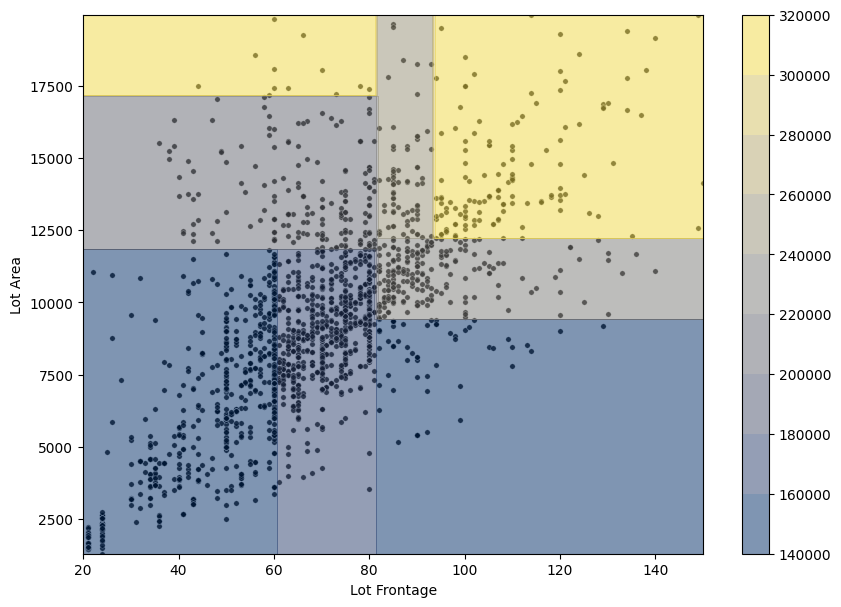

In [69]:
def plot_decision_bound_regression(X, y, model, fig):
    xx1, xx2 = np.meshgrid(
        np.arange(X.iloc[:, 0].min()-1, X.iloc[:, 0].max()+1, 1),
        np.arange(X.iloc[:, 1].min()-1, X.iloc[:, 1].max()+1, 1)
    )
    X_net = np.hstack([xx1.reshape(-1, 1), xx2.reshape(-1, 1)])
    y_pred = model.predict(X_net)
    y_pred = y_pred.reshape(xx1.shape)
    sns.scatterplot(x=X.iloc[:, 0], y=X.iloc[:, 1], s=15, color='black', alpha=0.8)
    contour = plt.contourf(xx1, xx2, y_pred, 10, cmap='cividis', alpha=0.5)
    fig.colorbar(contour)

# Визуализируем разделяющую поверхность дерева решений
fig = plt.figure(figsize = (10, 7))
plot_decision_bound_regression(X, y, dt_reg, fig)

In [70]:
# Создаём обучающую выборку    
bill_data = pd.read_csv('bill_authentication.csv')
X = bill_data[['Variance', 'Skewness']]
y = bill_data['Class']

In [71]:
# Инициализируем модель дерева решений с максимальной глубиной 4 и обучаем её
dt_clf = tree.DecisionTreeClassifier(max_depth=4)
dt_clf.fit(X.values, y)

DecisionTreeClassifier(max_depth=4)

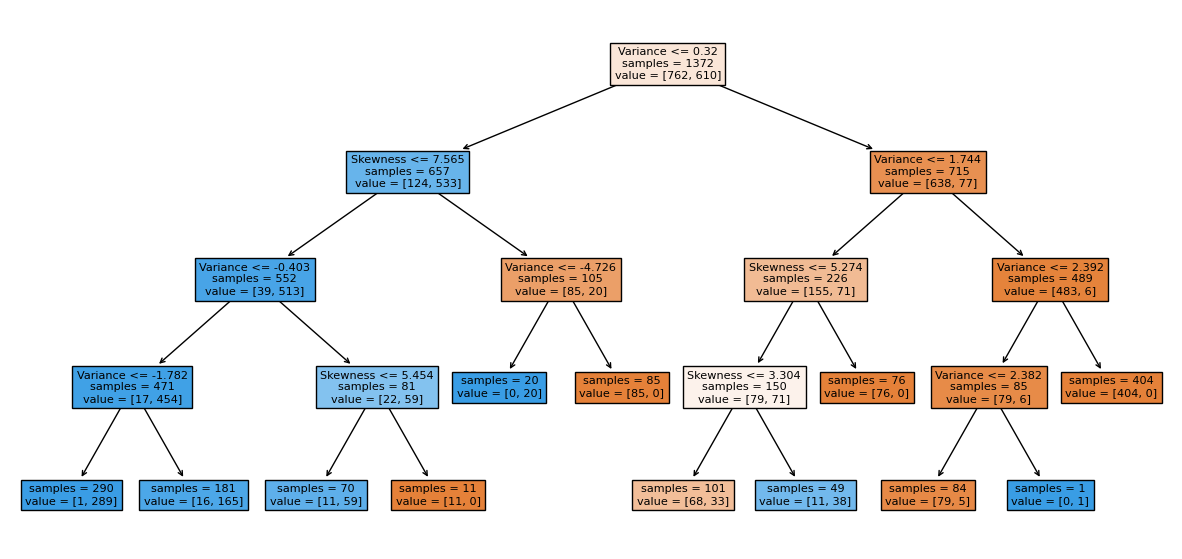

In [72]:
# Визуализируем дерево решений в виде графа
fig = plt.figure(figsize=(15, 7))
tree_graph = tree.plot_tree(
    dt_clf, #дерево решений
    feature_names=X.columns, #имена факторов
    filled=True, #расцветка
    impurity=False, #отображать ли неоднородность
);

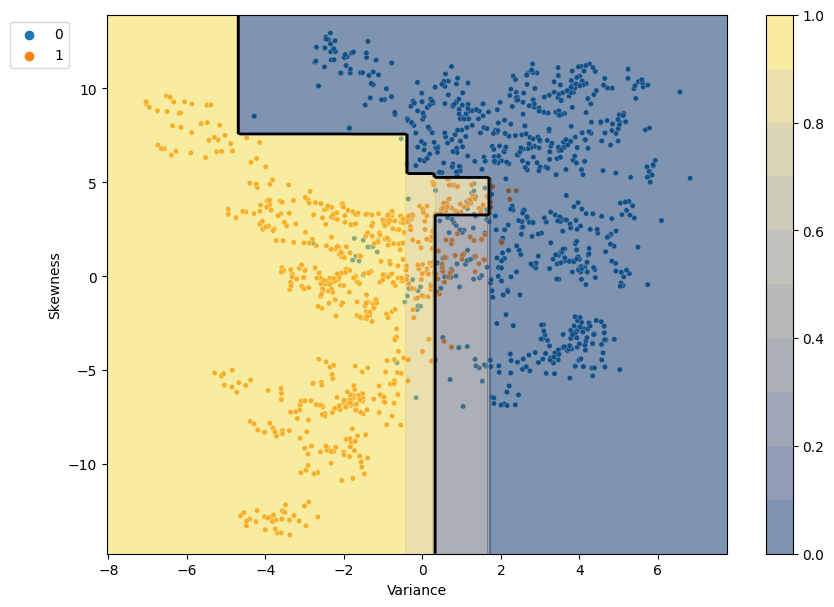

In [73]:
def plot_decision_bound_classification(X, y, model, fig):
    xx1, xx2 = np.meshgrid(
        np.arange(X.iloc[:, 0].min()-1, X.iloc[:, 0].max()+1, 0.1),
        np.arange(X.iloc[:, 1].min()-1, X.iloc[:, 1].max()+1, 0.1)
    )
    X_net = np.hstack([xx1.reshape(-1, 1), xx2.reshape(-1, 1)])
    probs = model.predict_proba(X_net)[:, 1]
    probs = probs.reshape(xx1.shape)
    
    sns.scatterplot(x=X.iloc[:, 0], y=X.iloc[:, 1], hue=y, s=15, alpha=1)
    contour = plt.contourf(xx1, xx2, probs, 10, cmap='cividis', alpha=0.5)
    bound = plt.contour(xx1, xx2, probs, [0.5], linewidths=2, colors='black');
    fig.colorbar(contour)
    plt.legend(bbox_to_anchor=(-0.05, 1))
# Визуализируем разделяющую поверхность дерева решений
fig = plt.figure(figsize = (10, 7))
plot_decision_bound_classification(X, y, dt_clf, fig)

In [74]:
def find_candidates_for_thresholds(x, y):
    x = x.sort_values().drop_duplicates()
    x_roll_mean = x.rolling(2).mean().dropna()
    y = y[x_roll_mean.index]
    y_roll_mean = y.diff()
    candidates = x_roll_mean[y_roll_mean != 0]
    return candidates.values

In [75]:
ames_data = pd.read_csv('AmesHousing.csv')
ames_data = ames_data[(ames_data['Lot Frontage'] <=150) & (ames_data['Lot Area'] <=20000)]
ames_sample = ames_data[['Lot Frontage', 'Lot Area', 'SalePrice']].sample(
    n=15, #количество объектов
    random_state=42, #генератор случайных чисел
    ignore_index=True #сбрасываем счетчик индекса
)
print(find_candidates_for_thresholds(
    ames_sample['Lot Frontage'], 
    ames_sample['SalePrice']
))

[ 53.  58.  61.  65.  69.  71.  76.  86.  94. 101.]


In [76]:
print(find_candidates_for_thresholds(
    ames_sample['Lot Area'], 
    ames_sample['SalePrice']
))

[ 5508.   7153.   7425.   7949.   8405.5  8526.5  8850.   9137.5  9466.
 10051.5 10507.  10834.  11365.  12288. ]


In [77]:
ames_data = ames_data[(ames_data["Lot Frontage"] <=150) & (ames_data["Lot Area"] <=20000)]

ames_sample = ames_data[["Lot Frontage", "Lot Area", "SalePrice"]].sample(
    n=15, random_state=42, ignore_index=True
)

X = ames_sample[["Lot Frontage", "Lot Area"]]
y = ames_sample["SalePrice"]

In [78]:
def squared_error(y):
    y_pred = y.mean()
    return ((y - y_pred) ** 2).mean()

def split(X, y, split_params):
    j, t = split_params
    predicat = X.iloc[:, j] <= t
    X_left, y_left = X[predicat], y[predicat]
    X_right, y_right = X[~predicat], y[~predicat]
    return X_left, y_left, X_right, y_right

def calculate_weighted_impurity(X, y, split_params, criterion):
    X_left, y_left, X_right, y_right = split(X, y, split_params)
    N, N_left, N_right  = y.size, y_left.size, y_right.size
    score = N_left / N * criterion(y_left) + N_right / N * criterion(y_right)
    return score

def best_split(X, y, criterion):
    M = X.shape[1]
    min_weighted_impurity = np.inf
    optimal_split_params = None
    for j in range(M):
        thresholds = find_candidates_for_thresholds(X.iloc[:, j], y)
        for t in thresholds:
            split_params = (j, t)
            weighted_impurity = calculate_weighted_impurity(X, y, split_params, criterion)
            if weighted_impurity < min_weighted_impurity:
                min_weighted_impurity = weighted_impurity
                optimal_split_params = split_params
    return optimal_split_params

Optimal j: 0
Optimal t: 71
Weighted impurity: 1414654917


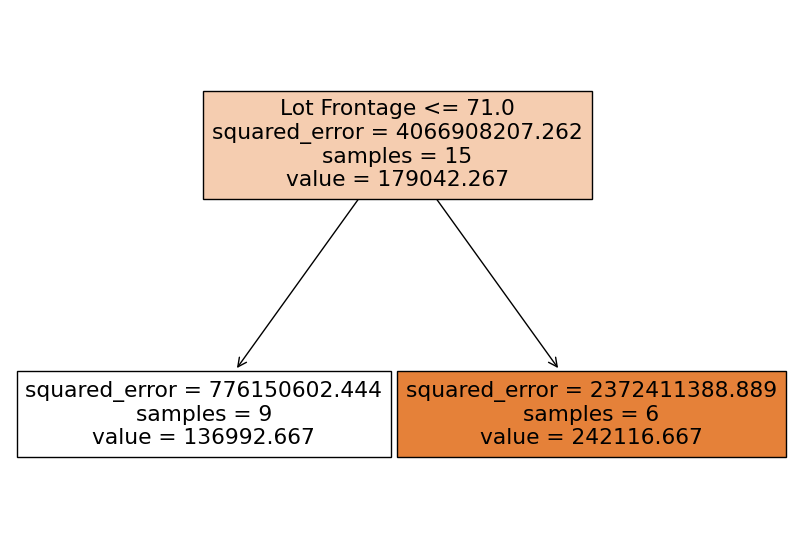

In [79]:
# Находим оптимальные параметры разбиения
optimal_params = best_split(X, y, criterion=squared_error)
print('Optimal j: {}'.format(optimal_params[0]))
print('Optimal t: {:.0f}'.format(optimal_params[1]))
print('Weighted impurity: {:.0f}'.format(calculate_weighted_impurity(X, y, optimal_params, criterion=squared_error)))

# Инициализируем модель дерева решений с максимальной глубиной 1 и обучаем её
dt = tree.DecisionTreeRegressor(max_depth=1, criterion='squared_error', random_state=0)
dt.fit(X, y)
# Визуализируем дерево решений в виде графа
fig = plt.figure(figsize = (10, 7))
tree.plot_tree(
    decision_tree=dt, #дерево решений 
    feature_names=X.columns, #названия факторов
    filled=True, #расцветка
    impurity=True, #отображать ли неоднородность в вершинах
);

In [80]:
bill_data = pd.read_csv('bill_authentication.csv')
bill_sample = bill_data[['Variance', 'Skewness', 'Class']].sample(
    n=15, 
    random_state=42, 
    ignore_index=True
)
# Создаём обучающую выборку
X = bill_sample[['Variance', 'Skewness']]
y = bill_sample['Class']

In [81]:
def entropy(y):
    p = y.value_counts(normalize=True)
    entropy = -np.sum(p * np.log2(p))
    return entropy

Optimal j: 1
Optimal t: 3.221
Impurity: 0.460


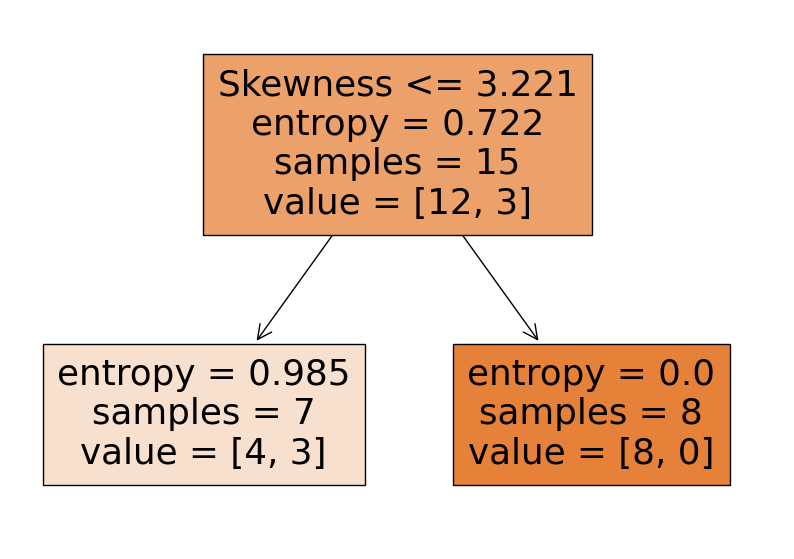

In [82]:
# Находим оптимальные параметры разбиения
optimal_params = best_split(X, y, criterion=entropy)
print('Optimal j: {}'.format(optimal_params[0]))
print('Optimal t: {:.3f}'.format(optimal_params[1]))
print('Impurity: {:.3f}'.format(calculate_weighted_impurity(X, y, optimal_params, criterion=entropy)))

# Инициализируем модель дерева решений с максимальной глубиной 1 и обучаем её
dt = tree.DecisionTreeClassifier(max_depth=1, criterion='entropy', random_state=0)
dt.fit(X, y)
# Визуализируем дерево решений в виде графа
fig = plt.figure(figsize = (10, 7))
tree.plot_tree(
    decision_tree=dt, #дерево решений 
    feature_names=X.columns, #названия факторов
    filled=True, #расцветка
    impurity=True, #отображать ли неоднородность в вершинах
);

In [83]:
bill_data = pd.read_csv('bill_authentication.csv')
bill_sample = bill_data[['Variance', 'Skewness', 'Class']].sample(
    n=15, 
    random_state=42, 
    ignore_index=True
)
# Создаём обучающую выборку
X = bill_sample[['Variance', 'Skewness']]
y = bill_sample['Class']

In [84]:
class Node:
    def __init__(self, left=None, 
                 right=None, value=None, 
                 split_params=None, impurity=None,
                 samples=None, is_leaf=False):
        self.left = left
        self.right = right
        self.split_params = split_params
        self.value = value
        self.impurity = impurity
        self.samples = samples
        self.is_leaf = is_leaf

def create_leaf_prediction(y):
    value = y.mode()[0]
    return value

def stopping_criterion(X, y, criterion):
    return criterion(y) == 0

def build_decision_tree(X, y, criterion):
    if stopping_criterion(X, y, criterion):
        value = create_leaf_prediction(y)
        node = Node(
            value=value, 
            impurity=criterion(y), 
            samples=y.size,
            is_leaf=True
        )
    else:
        split_params = best_split(X, y, criterion=entropy)
        X_left, y_left, X_rigth, y_right = split(X, y, split_params)
        left = build_decision_tree(X_left, y_left, criterion)
        right = build_decision_tree(X_rigth, y_right, criterion)       
        node = Node(
            left=left, right=right, 
            split_params=split_params, 
            impurity=criterion(y), 
            samples=y.size
        )
    return node

def print_decision_tree(node, depth=0):
    depth += 1
    if node.is_leaf:
        print('   ' * depth, 'class: {}'.format(node.value))
    else:
        print('   ' * depth, 'feature_{} <= {:.3f}:'.format(*node.split_params))
        print_decision_tree(node.left, depth=depth)
        print('   ' * depth, 'feature_{} > {:.3f}:'.format(*node.split_params))
        print_decision_tree(node.right, depth=depth)

    feature_1 <= 3.221:
       feature_0 <= 2.756:
          feature_0 <= -1.254:
             class: 0
          feature_0 > -1.254:
             feature_0 <= -0.063:
                class: 1
             feature_0 > -0.063:
                feature_0 <= 0.988:
                   class: 0
                feature_0 > 0.988:
                   class: 1
       feature_0 > 2.756:
          class: 0
    feature_1 > 3.221:
       class: 0
5


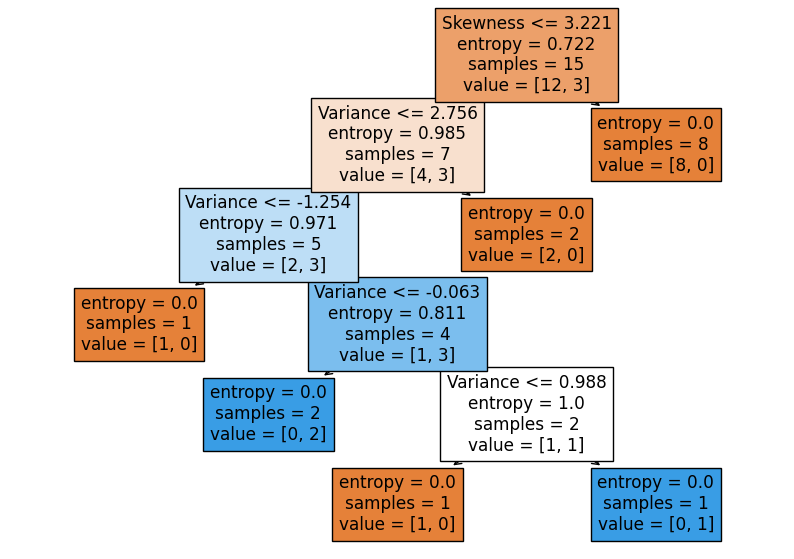

In [85]:
# Строим дерево решений и выводим его на экран
decision_tree = build_decision_tree(X, y, criterion=entropy)
print_decision_tree(decision_tree)

# Инициализируем модель дерева решений с максимальной глубиной 1 и обучаем её
dt = tree.DecisionTreeClassifier(max_depth=None, criterion='entropy', random_state=0)
dt.fit(X, y)

# Визуализируем дерево решений в виде графа
fig = plt.figure(figsize = (10, 7))
tree.plot_tree(
    decision_tree=dt, # Дерево решений 
    feature_names=X.columns, # Названия факторов
    filled=True, # Расцветка
    impurity=True, # Отображать ли неоднородность в вершинах
);
print(dt.get_depth())

In [93]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn import tree
from sklearn import model_selection
from sklearn import metrics

In [94]:
voice_data = pd.read_csv('voice_gender.csv')
voice_data.head()

,meanfreq,sd,median,Q25,Q75,IQR,skew,kurt,sp.ent,sfm,...,centroid,meanfun,minfun,maxfun,meandom,mindom,maxdom,dfrange,modindx,label
0,0.059781,0.064241,0.032027,0.015071,0.090193,0.075122,12.863462,274.402905,0.893369,0.491918,...,0.059781,0.084279,0.015702,0.275862,0.007812,0.007812,0.007812,0.000000,0.000000,male
1,0.066009,0.067310,0.040229,0.019414,0.092666,0.073252,22.423285,634.613855,0.892193,0.513724,...,0.066009,0.107937,0.015826,0.250000,0.009014,0.007812,0.054688,0.046875,0.052632,male
2,0.077316,0.083829,0.036718,0.008701,0.131908,0.123207,30.757155,1024.927705,0.846389,0.478905,...,0.077316,0.098706,0.015656,0.271186,0.007990,0.007812,0.015625,0.007812,0.046512,male
3,0.151228,0.072111,0.158011,0.096582,0.207955,0.111374,1.232831,4.177296,0.963322,0.727232,...,0.151228,0.088965,0.017798,0.250000,0.201497,0.007812,0.562500,0.554688,0.247119,male
4,0.135120,0.079146,0.124656,0.078720,0.206045,0.127325,1.101174,4.333713,0.971955,0.783568,...,0.135120,0.106398,0.016931,0.266667,0.712812,0.007812,5.484375,5.476562,0.208274,male


In [95]:
voice_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3168 entries, 0 to 3167
Data columns (total 21 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   meanfreq  3168 non-null   float64
 1   sd        3168 non-null   float64
 2   median    3168 non-null   float64
 3   Q25       3168 non-null   float64
 4   Q75       3168 non-null   float64
 5   IQR       3168 non-null   float64
 6   skew      3168 non-null   float64
 7   kurt      3168 non-null   float64
 8   sp.ent    3168 non-null   float64
 9   sfm       3168 non-null   float64
 10  mode      3168 non-null   float64
 11  centroid  3168 non-null   float64
 12  meanfun   3168 non-null   float64
 13  minfun    3168 non-null   float64
 14  maxfun    3168 non-null   float64
 15  meandom   3168 non-null   float64
 16  mindom    3168 non-null   float64
 17  maxdom    3168 non-null   float64
 18  dfrange   3168 non-null   float64
 19  modindx   3168 non-null   float64
 20  label     3168 non-null   obje

In [96]:
voice_data.isnull().sum().sum()

0

In [97]:
voice_data['label'] = voice_data['label'].apply(lambda x: 0 if x == 'male' else 1)
display(voice_data['label'].value_counts())

label
0    1584
1    1584
Name: count, dtype: int64

In [98]:
X = voice_data.drop(columns='label')
y = voice_data['label']

In [99]:
# Формируем обучающую и тестовую выборки
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
print('Train shape: {}'.format(X_train.shape))
print('Test shape: {}'.format(X_test.shape))

Train shape: (2534, 20)
Test shape: (634, 20)


In [101]:
def find_candidates_for_thresholds(x, y):
    x = x.sort_values().drop_duplicates()
    x_roll_mean = x.rolling(2).mean().dropna()
    y = y[x_roll_mean.index]
    y_roll_mean = y.diff()
    candidates = x_roll_mean[y_roll_mean != 0]
    return candidates.values

def entropy(y):
    p = y.value_counts(normalize=True)
    entropy = -np.sum(p * np.log2(p))
    return entropy

def squared_error(y):
    y_pred = y.mean()
    return ((y - y_pred) ** 2).mean()

def split(X, y, split_params):
    j, t = split_params
    predicat = X.iloc[:, j] <= t
    X_left, y_left = X[predicat], y[predicat]
    X_right, y_right = X[~predicat], y[~predicat]
    return X_left, y_left, X_right, y_right

def calculate_weighted_impurity(X, y, split_params, criterion):
    X_left, y_left, X_right, y_right = split(X, y, split_params)
    N, N_left, N_right  = y.size, y_left.size, y_right.size
    score = N_left / N * criterion(y_left) + N_right / N * criterion(y_right)
    return score

def best_split(X, y, criterion):
    M = X.shape[1]
    min_weighted_impurity = np.inf
    optimal_split_params = None
    for j in range(M):
        thresholds = find_candidates_for_thresholds(X.iloc[:, j], y)
        for t in thresholds:
            split_params = (j, t)
            weighted_impurity = calculate_weighted_impurity(X, y, split_params, criterion)
            if weighted_impurity < min_weighted_impurity:
                min_weighted_impurity = weighted_impurity
                optimal_split_params = split_params
    return optimal_split_params

TypeError: can only concatenate str (not "numpy.int64") to str

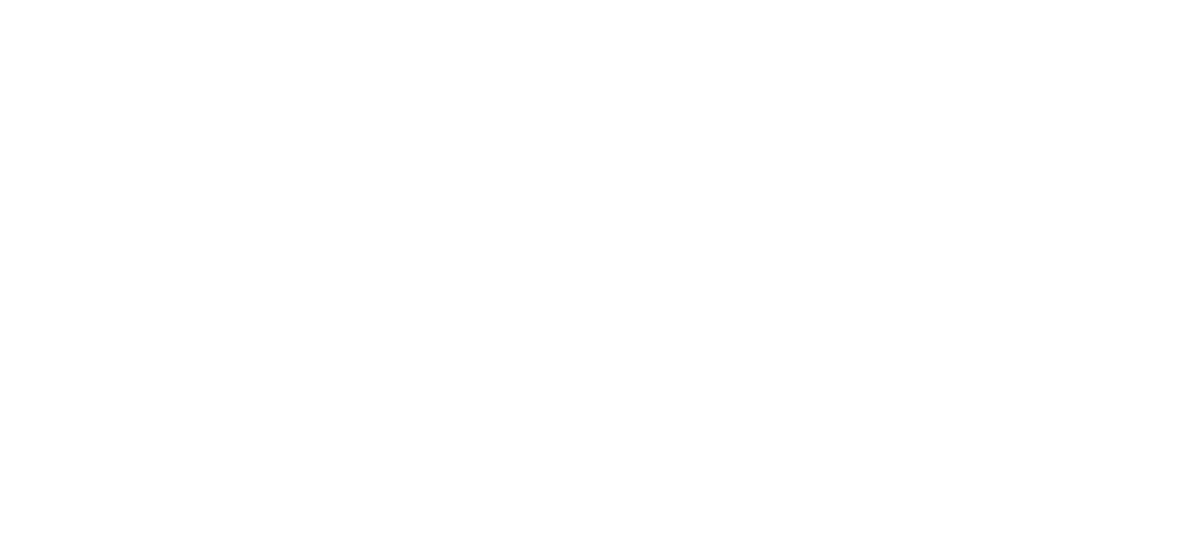

In [109]:
# Инициализируем модель дерева решений с глубиной 1 и обучаем ее
dt = tree.DecisionTreeClassifier(
    max_depth=1, #глубина
    criterion='entropy' #критерий информативности
)
dt.fit(X_train, y_train)

# Визуализируем дерево решений в виде графа
fig = plt.figure(figsize=(15, 7))
tree_graph = tree.plot_tree(
    decision_tree=dt, #дерево
    feature_names=X.columns, #имена факторов
    proportion=True, #выводить ли количество данных в пропорциях
    filled=True, #расцветка
    class_names=dt.classes_, #имена классов
);
# Делаем предсказание
y_test_pred = dt.predict(X_test)
# Считаем метрику accuracy на тестовой выборке
print('Accuracy: {:.3f}'.format(metrics.accuracy_score(y_test, y_test_pred)))

Accuracy: 0.959


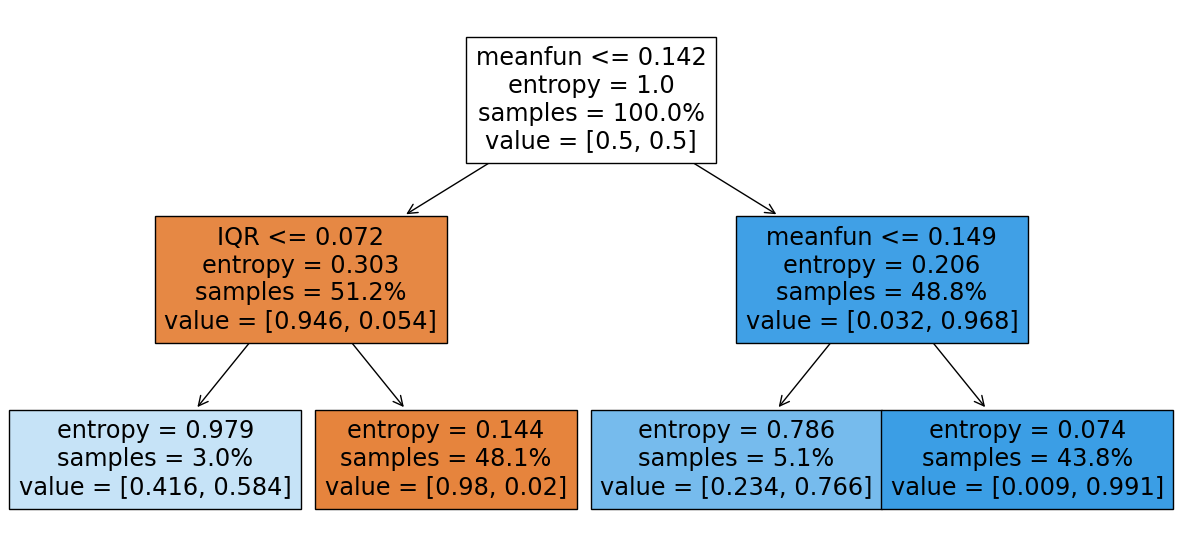

In [105]:
# Инициализируем модель дерева решений с глубиной 1 и обучаем ее
dt = tree.DecisionTreeClassifier(
    max_depth=2, #глубина
    criterion='entropy', #критерий информативности
    random_state=42
)
dt.fit(X_train, y_train)
# Визуализируем дерево решений в виде графа
fig = plt.figure(figsize=(15, 7))
tree_graph = tree.plot_tree(
    decision_tree=dt, #дерево
    feature_names=X.columns, #имена факторов
    proportion=True, #выводить ли количество данных в пропорциях
    filled=True, #расцветка
    # class_names=dt.classes_, #имена классов
);
# Делаем предсказание
y_test_pred = dt.predict(X_test)
# Считаем метрику accuracy на тестовой выборке
print('Accuracy: {:.3f}'.format(metrics.accuracy_score(y_test, y_test_pred)))

In [106]:
# Инициализируем модель дерева решений с глубиной 1 и обучаем ее
dt = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности
    random_state=0 #генератор случайных чисел
)
dt.fit(X_train, y_train)
print('Depth: {}'.format(dt.get_depth()))
print('Count of leaves: {}'.format(dt.get_n_leaves()))
# Делаем предсказание
y_train_pred = dt.predict(X_train)
y_test_pred = dt.predict(X_test)
# Считаем метрику accuracy на обучающей и тестовой выборках
print('Train accuracy: {:.3f}'.format(metrics.accuracy_score(y_train, y_train_pred)))
print('Test accuracy: {:.3f}'.format(metrics.accuracy_score(y_test, y_test_pred)))

Depth: 10
Count of leaves: 50
Train accuracy: 1.000
Test accuracy: 0.962


In [108]:
# Задаем сетку параметров
param_grid = {
    'criterion': ['gini', 'entropy'], #критерий информативности
    'max_depth': [4, 5, 6, 7, 8, 9, 10], #максимальная глубина дерева
    'min_samples_split': [3, 4, 5, 10] #минимальное количество объектов, необходимое для сплита
}

# Задаем метод кросс-валидации
cv = model_selection.StratifiedKFold(n_splits=5)

# Инициализируем поиск на сетке и обучаем его
gs = model_selection.GridSearchCV(
    estimator=tree.DecisionTreeClassifier(random_state=0), #модель
    param_grid=param_grid, #сетка параметров
    scoring='accuracy', #метрика
    cv=cv, #кросс-валидатор
    n_jobs=-1 #используем все мощности процессора
)
gs.fit(X_train, y_train)
print(gs.best_params_)
# Определяем наилучшую модель
best_tree = gs.best_estimator_

# Делаем предсказание
y_train_pred = best_tree.predict(X_train)
y_test_pred = best_tree.predict(X_test)
# Считаем метрику accuracy на обучающей и тестовой выборках
print('Train accuracy: {:.3f}'.format(metrics.accuracy_score(y_train, y_train_pred)))
print('Test accuracy: {:.3f}'.format(metrics.accuracy_score(y_test, y_test_pred)))

{'criterion': 'entropy', 'max_depth': 6, 'min_samples_split': 4}
Train accuracy: 0.992
Test accuracy: 0.967


In [110]:
a = np.array([4.4, 3.8, 4.8, 4.0, 3.4, 4.2, 5.2])
b = a.mean()
np.sum((a - b)**2)/7

0.31673469387755115

In [ ]:
df['target']= np.where(df.quality >=6,1,0)
Y= df['target']
X = df.drop(['target', 'quality'], axis= 1)
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.3, random_state=42)
model = LogisticRegression()
model.fit(X_train, y_train)
preds_train = model.predict(X_train)
preds_test = model.predict(X_test)
f1_score(preds_test, y_test)
model = DecisionTreeClassifier(max_depth = 10, random_state=42)
model.fit(X_train, y_train)
preds_train = model.predict(X_train)
preds_test = model.predict(X_test)
f1_score(preds_test, y_test)